In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
class LinModel(torch.nn.Module):
    def __init__(self, input_dim=1, output_dim=3, bias=True) -> None:
        super().__init__()
        self.layer = torch.nn.Linear(input_dim, output_dim, bias=bias)

    def forward(self, x):
        return self.layer(x)
    

In [3]:
model = LinModel()
model.layer.weight.data = torch.tensor([0.7,0.25,0.9]).view(-1,1)
model.layer.bias.data = torch.tensor([1.0, -0.4, 0.5])

for name, parameters in model.named_parameters():
    print(name,parameters)

layer.weight Parameter containing:
tensor([[0.7000],
        [0.2500],
        [0.9000]], requires_grad=True)
layer.bias Parameter containing:
tensor([ 1.0000, -0.4000,  0.5000], requires_grad=True)


In [4]:
test_P = torch.linspace(-6,6,7)
test_P

tensor([-6., -4., -2.,  0.,  2.,  4.,  6.])

In [5]:
predicted_weights = model.forward(test_P.view(-1,1))
predicted_weights

tensor([[-3.2000, -1.9000, -4.9000],
        [-1.8000, -1.4000, -3.1000],
        [-0.4000, -0.9000, -1.3000],
        [ 1.0000, -0.4000,  0.5000],
        [ 2.4000,  0.1000,  2.3000],
        [ 3.8000,  0.6000,  4.1000],
        [ 5.2000,  1.1000,  5.9000]], grad_fn=<AddmmBackward0>)

In [6]:
def my_softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1)[:,None]

predicted_probabilities = my_softmax(predicted_weights)
predicted_probabilities

tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<DivBackward0>)

In [7]:
torch_softmax = torch.nn.Softmax(dim=1) #Not really sure what dim does, i suppose it is the same as above, where dim chooses the axis along which to sum?
predicted_probabilities = torch_softmax(predicted_weights) 
predicted_probabilities #Here we then get the probability dist Q of each point xi in test_P is labelled 0,1 or 2

tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<SoftmaxBackward0>)

In [8]:
#We now implement the cross entropy where we consider the probability dist. Q. We calculate it by saying.
#Given that we have an x, and assign it some label, 0,1 or 2. We then calculate Q(x, label), given by the NN and softmax.
#When we do this we plug the number into the formula for cross entropy.
def cross_entropy_my_version(probabilities, guessed_labels):
    probs = torch.zeros(len(probabilities))
    i=0
    for guessed_label, probability in zip(guessed_labels, probabilities):
        probs[i] = probability[guessed_label]
        i+=1
    return -torch.mean(torch.log(probs))

def cross_entropy_from_probabilities(probabilities, guessed_labels):
    probabilities_for_guessed_labels = torch.gather(probabilities, #Here we can use torch.gather which utilizes the fact that it gathers each element in "probabilites"                   
                                                    dim=1,          #That belong to the label index given in the guessed labels
                                                    index=guessed_labels.unsqueeze(1))
    return -torch.mean(torch.log(probabilities_for_guessed_labels)) #Here we simply insert the formula for cross entropy



In [9]:
print(cross_entropy_my_version(predicted_probabilities, torch.tensor([2,0,2,0,2,1,2])))
print(cross_entropy_from_probabilities(predicted_probabilities, torch.tensor([2,0,2,0,2,1,2]))) #Why does it make sense that i get different cross entropies, depending on how many points i have?
criterion = torch.nn.CrossEntropyLoss()
print(criterion(predicted_weights, torch.tensor([2,0,2,0,2,1,2])))

tensor(1.6841, grad_fn=<NegBackward0>)
tensor(1.6841, grad_fn=<NegBackward0>)
tensor(1.6841, grad_fn=<NllLossBackward0>)


In [10]:
#In our case we want to see which labeling we should give our randomly distributed weights in order to minimize H(P,Q)
lowest_H = None
for i in range(20000):
    random_label = torch.randint(0,3, (1,7))[0]
    H = cross_entropy_from_probabilities(probabilities=predicted_probabilities, guessed_labels=random_label)
    if lowest_H is None:
        lowest_H = H
        print(H, random_label)
    elif H <= lowest_H:
        lowest_H = H
        print(lowest_H, random_label)

tensor(1.5841, grad_fn=<NegBackward0>) tensor([2, 1, 0, 0, 0, 1, 0])
tensor(1.2412, grad_fn=<NegBackward0>) tensor([0, 1, 0, 2, 1, 2, 0])
tensor(0.7412, grad_fn=<NegBackward0>) tensor([0, 1, 0, 0, 0, 2, 2])
tensor(0.7412, grad_fn=<NegBackward0>) tensor([1, 1, 1, 0, 2, 2, 0])
tensor(0.6698, grad_fn=<NegBackward0>) tensor([1, 1, 1, 0, 0, 0, 2])
tensor(0.6698, grad_fn=<NegBackward0>) tensor([1, 1, 1, 0, 0, 0, 2])
tensor(0.6127, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 2, 0, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackward0>) tensor([1, 1, 0, 0, 0, 2, 2])
tensor(0.5555, grad_fn=<NegBackwar

In [11]:
def my_softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1)[:,None]

class LinModel(torch.nn.Module):
    def __init__(self, input_dim=1, output_dim=3, bias=True) -> None:
        super().__init__()
        self.layer = torch.nn.Linear(input_dim, output_dim, bias=bias)

    def forward(self, x):
        return self.layer(x)
    
    def predict_label(self, x):
        probs = my_softmax(self(x))
        return torch.argmax(probs, dim=1)

In [12]:
model = LinModel()
model.layer.weight.data = torch.tensor([0.7,0.25,0.9]).view(-1,1)
model.layer.bias.data = torch.tensor([1.0, -0.4, 0.5])

label_vector = model.predict_label(test_P.view(-1,1))
label_vector

tensor([1, 1, 0, 0, 0, 2, 2])

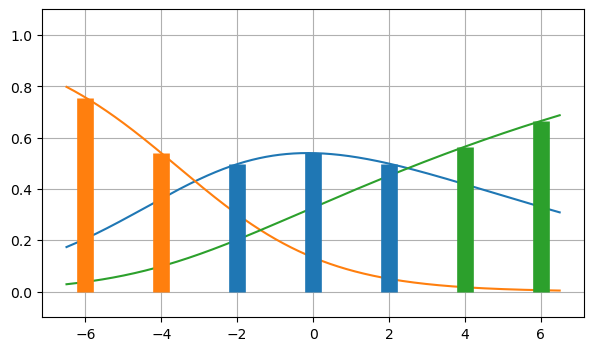

In [13]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_ylim([-0.1, 1.1])
xs = torch.linspace(-6.5, 6.5, 1000)
probs = my_softmax(model.forward(xs.view(-1,1)))
probs_disc = my_softmax(model.forward(test_P.view(-1,1)))
with torch.no_grad():
    for i in range(3):
        ax.plot(xs, probs[:,i])
    for prob_disc, label, x_val, in zip(probs_disc, label_vector, test_P):
        ax.vlines(x=x_val, ymin=0.0, ymax=prob_disc[label], color=f"C{label}",lw=12)
ax.grid() #I do not really understand the bars in bjørks plot. ? I suppose binnning the distributions would give me the right results?

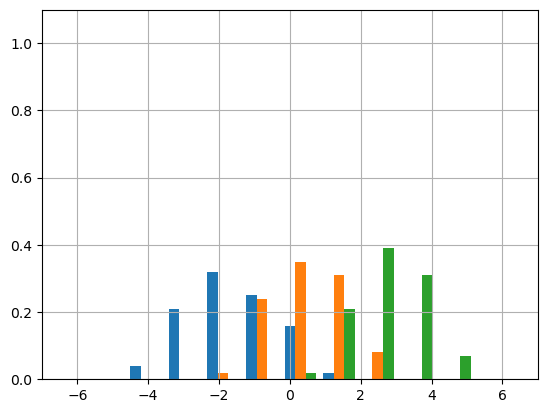

In [14]:
l0 = torch.randn(100)*np.sqrt(2.0) - 2.0
l1 = torch.randn(100)*np.sqrt(1.0) + 0.5
l2 = torch.randn(100)*np.sqrt(1.0) + 3.0

fig, ax = plt.subplots()
ax.set_xlim([-7,7])
ax.set_ylim([-0,1+0.1])
with torch.no_grad():
    for i,l in enumerate([l0, l1, l2]):
        bin_edges = torch.linspace(-6+i*0.3, 6+i*0.3, 12) #Plotted it such that each distribution gets shifted, so that they are visible. :)
        hist, bins = torch.histogram(l, bins=bin_edges)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        ax.bar(bin_centers, hist/torch.sum(hist), width=0.3)
ax.grid()

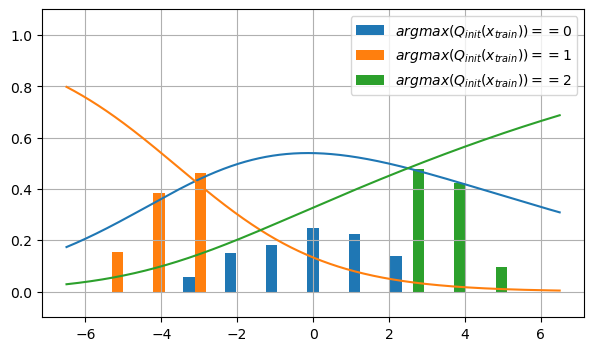

In [15]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_ylim([-0.1, 1.1])
xs = torch.linspace(-6.5, 6.5, 1000)
probs = my_softmax(model.forward(xs.view(-1,1)))
l_tot = torch.concatenate((l0,l1,l2)).view(-1,1)
probs_disc = my_softmax(model.forward(l_tot))
labels = model.predict_label(l_tot)
with torch.no_grad():
    for i in range(3):
        ax.plot(xs, probs[:,i])
        tens = torch.argwhere(labels == i)
        x_pred = l_tot[tens].squeeze(1)
        bin_edges = torch.linspace(-6+i*0.3, 6+i*0.3, 12)
        hist, bins = torch.histogram(x_pred, bins=bin_edges)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        ax.bar(bin_centers, hist/torch.sum(hist), width=0.3, label=r"$argmax(Q_{init}(x_{train}))==$"+f"{i}")
ax.legend()
ax.grid()

In [16]:
def train_model(data_loader, model,optimizer, num_epochs=100, loss_func=torch.nn.CrossEntropyLoss()):
    for epoch in range(num_epochs):
        for features, labels in data_loader:
            optimizer.zero_grad()
            loss = loss_func(model.forward(features), labels)
            loss.backward()
            optimizer.step()

class CustomDataset(Dataset):
    def __init__(self, features, labels) -> None:
        super().__init__()
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [19]:
train_data = CustomDataset(features=l_tot, labels=torch.concat((torch.zeros(100, dtype=int),torch.ones(100, dtype=int),(2*torch.ones(100, dtype=int)))))
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True) #We just make it all into one batch

model = LinModel()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
train_model(data_loader=train_loader, model=model, optimizer=optimizer, num_epochs=10000, loss_func=torch.nn.CrossEntropyLoss())

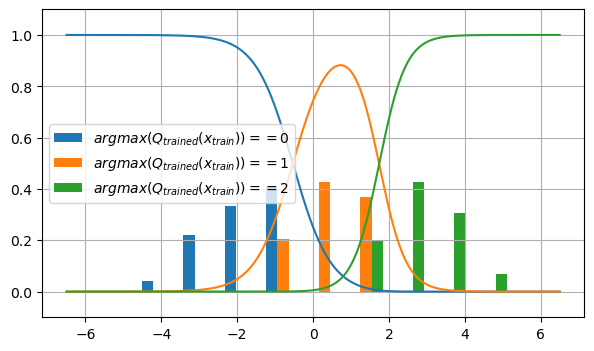

In [20]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_ylim([-0.1, 1.1])
xs = torch.linspace(-6.5, 6.5, 1000)
probs = my_softmax(model.forward(xs.view(-1,1)))
l_tot = torch.concatenate((l0,l1,l2)).view(-1,1)
probs_disc = my_softmax(model.forward(l_tot))
labels = model.predict_label(l_tot)
with torch.no_grad():
    for i in range(3):
        ax.plot(xs, probs[:,i])
        tens = torch.argwhere(labels == i)
        x_pred = l_tot[tens].squeeze(1)
        bin_edges = torch.linspace(-6+i*0.3, 6+i*0.3, 12)
        hist, bins = torch.histogram(x_pred, bins=bin_edges)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        ax.bar(bin_centers, hist/torch.sum(hist), width=0.3, label=r"$argmax(Q_{trained}(x_{train}))==$"+f"{i}")
ax.legend()
ax.grid()

In [ ]:
#Need to plot the probabability binning of the new distributions
#Need to fix the bins in the plot earlier, similar to the plot i need to do here.